## Evolving Correlations

### Summary 
In this note, I team up with Jack DiMassimo from MarketStrats and use `gs_quant` to analyze changes to the correlation structure among assets. We explore where there may be opportunities to trade assets that have strayed from their traditional relationships because of temporary factors. 

To do this, we perform a PCA and rolling PCA analysis on the correlation matrix of 19 assets sourced from FRED covering global Equities, Rates, FX, Commodities, and Vol. 

We find that:
* Most of the explanatory power is dominated by the first two components where the first component aligns with risk / growth and the second with real rates. Deeper dive in [3 - Interpreting the top 2](#3---Interpreting-the-top-2)
* US equities, unsurprisingly, have realized much higher than the model predicts
* JPY, WTI and US 2y have realized much lower than predicted suggesting other factors at play and potential opportunity for entry

In this analysis we leverage gs-quant FRED connector to pull data as well as a number of [timeseries functions](https://developer.gs.com/docs/gsquant/api/timeseries.html) to transform it.

Outside of this analysis, we hope you can keep using this notebook as a way to monitor changing drivers of risk and screen to mispriced trading opportunities. Please reach out with your feedback and suggestions!

Finally, check out the [What's New](#What's-New) section for the latest gs-quant additions.

The content of this notebook is split into:
* [1 - Grab the data](#1---Grab-the-data)
* [2 - Model explanatory factors through time](#2---Model-explanatory-factors-through-time)
* [3 - Interpreting the top 2](#3---Interpreting-the-top-2)
* [4 - Actual vs Predicted](#4---Actual-vs-Predicted)
* [What's New](#What's-New)

### 1 - Grab the data

First - the data. For this analysis I will use public data from [FRED](https://fred.stlouisfed.org/) but of course you can substitute or enhance this piece with your own data. The goal is to get a deep history accross multiple categories or sources we're interested in investigating.

I will use gs_quant FRED connector to pull in the data. For this, you will need to use your own FRED API key. Takes under a minute to create one [here](https://research.stlouisfed.org/useraccount/login/secure/). 

Note in the dictionary, I include a type to indicate whether to difference (b-a) or calculate returns (b/a-1) for each series and an asset class label that I will use later in the analysis.

In [51]:
import pandas as pd
from gs_quant.data import Dataset
from gs_quant.api.fred.data import FredDataApi

FRED_API_KEY = ''
fred_API = FredDataApi(api_key=FRED_API_KEY)

data = {
    'WILS': {'symbol': 'WILL5000INDFC', 'type': 'r', 'asset class': 'Equities'},
    'NDX': {'symbol': 'NASDAQ100', 'type': 'r', 'asset class': 'Equities'},
    'N225': {'symbol': 'NIKKEI225', 'type': 'r', 'asset class': 'Equities'},

    'EUR': {'symbol': 'DEXUSEU', 'type': 'r', 'asset class': 'FX'},
    'JPY': {'symbol': 'DEXJPUS', 'type': 'r', 'asset class': 'FX'},
    'AUD': {'symbol': 'DEXUSAL', 'type': 'r', 'asset class': 'FX'},
    'GBP': {'symbol': 'DEXUSUK', 'type': 'r', 'asset class': 'FX'},
    'CAD': {'symbol': 'DEXCAUS', 'type': 'r', 'asset class': 'FX'},

    'USD 2y': {'symbol': 'DGS2', 'type': 'd', 'asset class': 'Rates'},
    'USD 10y': {'symbol': 'DGS10', 'type': 'd', 'asset class': 'Rates'},
    '2Y10Y': {'symbol': 'T10Y2Y', 'type': 'd', 'asset class': 'Rates'},
    '10Y3M': {'symbol': 'T10Y3M', 'type': 'd', 'asset class': 'Rates'},
 
    'USD 5y RY': {'symbol': 'DFII5', 'type': 'd', 'asset class': 'Rates'},
    'USD 10y RY': {'symbol': 'DFII10', 'type': 'd', 'asset class': 'Rates'},
    'Breakevens': {'symbol': 'T10YIE', 'type': 'd', 'asset class': 'Rates'},
    
    'Gold': {'symbol': 'GOLDAMGBD228NLBM', 'type': 'r', 'asset class': 'Commodities'},
    'WTI': {'symbol': 'DCOILWTICO', 'type': 'r', 'asset class': 'Commodities'},   
    
    'HY': {'symbol': 'BAMLH0A0HYM2', 'type': 'd', 'asset class': 'Credit'},
    'VIX': {'symbol': 'VIXCLS', 'type': 'd', 'asset class': 'Vol'}
}

# build dataframe with all series 
df = pd.concat([Dataset(v['symbol'], fred_API).get_data() for _, v in data.items()], axis=1)
df.columns = data.keys()

# filter for when data is available accross all and clean
frame = df[df.index > '2003-01-01']
frame = frame.fillna(method='ffill').dropna()

# flip JPY and CAD for more intuitive direction in later analysis
frame['JPY'] = 1/frame['JPY']
frame['CAD'] = 1/frame['CAD']
frame['WTI'] = 100 + frame['WTI']  # negative prices!
frame.head(2)

,WILS,NDX,N225,EUR,JPY,AUD,GBP,CAD,USD 2y,USD 10y,2Y10Y,10Y3M,USD 5y RY,USD 10y RY,Breakevens,Gold,WTI,HY,VIX
date,,,,,,,,,,,,,,,,,,,
2003-01-06,29.49,1061.48,8713.33,1.0469,0.008399,0.5762,1.6080,0.641108,1.84,4.09,2.25,2.88,1.79,2.46,1.63,356.1,132.29,8.41,24.91
2003-01-07,29.29,1071.85,8656.50,1.0419,0.008321,0.5753,1.6055,0.641437,1.77,4.04,2.27,2.85,1.76,2.42,1.62,348.7,131.20,8.26,25.13


With all of our data in hand, let's standardize it by differencing levels and calculating returns. Note, I use a 2 day window to smooth the effect of comparing accross different markets. 

In [52]:
from gs_quant.timeseries import returns, diff

frame_t = frame.copy()
for key, v in data.items():
    frame_t[key] = returns(frame_t[key], 2) if v['type'] == 'r' else diff(frame_t[key], 2)
frame_t.dropna(inplace=True)

### 2 - Model explanatory factors through time

Now the fun part. Let's run a 3-factor PCA for a 42 day rolling period and record how much variance is explained by each component over our time frame. I standardize the values (0 mean, unit variance) to bring them to the same scale. Note, you can play around with number of components and time frame without having to change any code!

In [53]:
from sklearn.decomposition import PCA
from collections import defaultdict

period = 42
components = 3
f_loadings = defaultdict(list)

for start in range(len(frame_t) - period):
    d = frame_t.iloc[start:start + period]
    d = (d - d.mean()) / d.std()
    model = PCA(n_components=components)
    model.fit(d)
    for i, c in enumerate(model.explained_variance_ratio_):
        f_loadings[i].append(c)

Let's now look at variance explained by the top 3 components over time. I smooth the chart by looking at a 21d rolling average. 

Looking at the graph below, we can see the top 3 components explain ~65-85% of the variance over time. Additionally, variance explained most recently is among the highest over the period. This is not too surprising as with the high volatility we've seen correlations among many assets in question have increased significantly. 

As Jack pointed our in [his note](https://marquee.gs.com/s/content/articles/9ea25a7d-2560-4658-8122-2a5b1eff7d28), this is on par with the spikes observed during the GFC, Brexit, the August 2015 CNH devaluation, and the Eurozone Debt crisis. Notably, more equity specific crisis like the December 2018 SPX crash and the February 2018 'Volmageddon' lead to correlation spikes, but not to the extent observed during the more global events. 

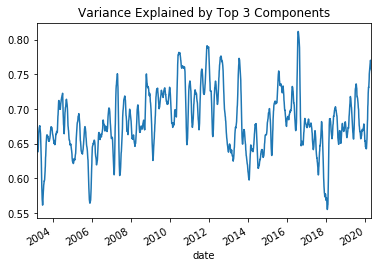

In [54]:
import matplotlib.pyplot as plt

factors = pd.DataFrame(f_loadings)
factors.index = frame_t.index[period:]
factors.sum(axis=1).rolling(21).mean().plot(title='Variance Explained by Top 3 Components')

Text(0.5, 1.0, 'Contribution to variance from each component')

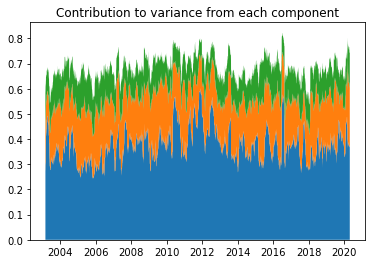

In [55]:
plt.stackplot(factors.index, factors.to_numpy().T)
plt.title('Contribution to variance from each component')

From the chart above, we can see the top 2 components dominate the varience explained so let's dig into them in a bit more detail to understand what they intuitively represent.

### 3 - Interpreting the top 2

In order to understand the most important factors that drive the structure of the correlation matrix we plot the loadings for each asset class against the first two PCs in the PCA over the full sample. This can allow us to visually identify how each asset class loads on the 2 principal components. If an asset or asset class has a high absolute value on one and not the other, we can say this is primary driver of this component.

Text(0, 0.5, 'PC2')

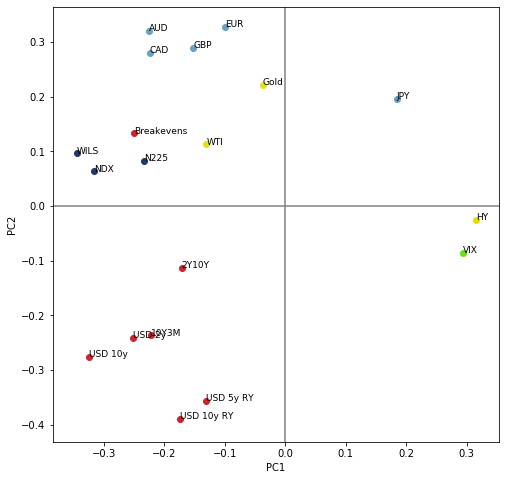

In [56]:
full_model = PCA(n_components=components)
full_data = (frame_t - frame_t.mean()) / frame_t.std()
full_model.fit(full_data)

components_full = pd.DataFrame(full_model.components_, columns=frame_t.columns)

fig = plt.figure(figsize=(8, 8))
color_map = {
    'Equities': '#20396D',
    'FX': '#68A2BF',
    'Rates': '#CD252B',
    'Commodities': '#E3E311',
    'Credit': '#E3E000',
    'Vol': '#67E311',
}

for i, row in components_full.iteritems():
    plt.scatter(row[0], row[1], color=color_map[data[row.name]['asset class']], label=row.name)
    plt.text(row[0], row[1], row.name, fontsize=9)

plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

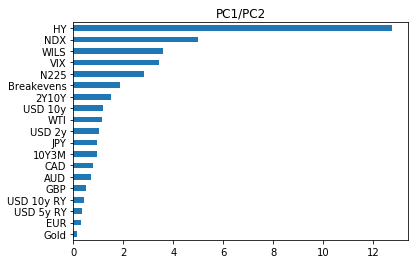

In [57]:
PC1, PC2 = components_full.iloc[0].abs(), components_full.iloc[1].abs()
(PC1/PC2).sort_values().plot(kind='barh', title='PC1/PC2')

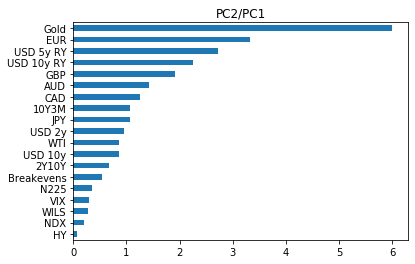

In [58]:
(PC2/PC1).sort_values().plot(kind='barh', title='PC2/PC1')

Looking at the above, some themes pop out for each of the components:
    
* PC1 = Growth/Risk (PC1): The primary driver of Equities, Credit, Vol
* PC2 = Real Rates (PC2): The primary driver of Gold, Real Rates, and FX (though FX is more mixed)

Let's now see how the loadings over the whole period compare to the most recent 42 day window to tell us how risk might have evolved.

Text(0, 0.5, 'PC2')

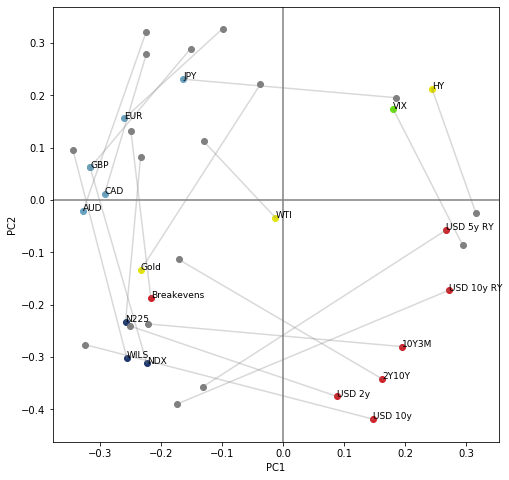

In [59]:
fig = plt.figure(figsize=(8, 8))

components_recent = pd.DataFrame(model.components_, columns=df.columns, index=factors.columns)

for (_, col1), (_, col2) in zip(components_full.iteritems(), components_recent.iteritems()):
    plt.scatter(col2[0], col2[1], color=color_map[data[col2.name]['asset class']], label=col2.name)
    plt.scatter(col1[0], col1[1], color='grey')
    plt.plot((col2[0], col1[0]), (col2[1], col1[1]), color='grey', alpha=0.3)
    plt.text(col2[0], col2[1], col1.name, fontsize=9)

plt.axhline(0, color='grey')
plt.axvline(0, color='grey')

plt.xlabel('PC1')
plt.ylabel('PC2')

As we can see in the above, this has been much rotation though equities, vol and credit are still primary drivers of PC1 and rates of PC2. One of the main changes is FX shifting towards PC1, reflect more about growth in the recent past.

### 4 - Actual vs Predicted

Now let's leverage this PCA model to predict where levels should be as explained by the top three factors (PC1 and PC2 discussed above as the primary two). Let's transform back the levels and plot actual vs predicted to see where there may be interesting disclocations.

In [60]:
pca_returns = pd.DataFrame(full_model.transform(full_data), index=full_data.index)
res = pca_returns.dot(components_full) * frame_t.std() + frame_t.mean()

In [61]:
def transform(tr_df, since):
    t_d = tr_df.copy()[since:]
    for key, v in t_d.items():
        t_d[key] = (1 + t_d[key] / 100).cumprod() if data[key]['type'] == 'r' else t_d[key].cumsum()
    return t_d

In [62]:
since = '2020-01-01'
predicted = transform(res, since)
actual = transform(frame_t, since)

In [63]:
def compare_plot(asset, actual, predicted):
    plt.figure(figsize=(6, 4))
    actual[asset].plot(label='actual')
    predicted[asset].plot(label='predicted')
    plt.title(asset)
    plt.legend()
    plt.show()

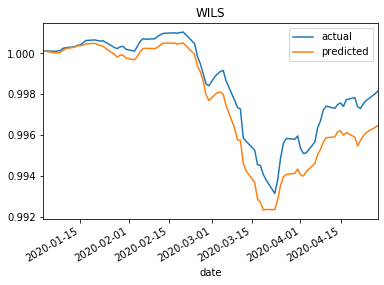

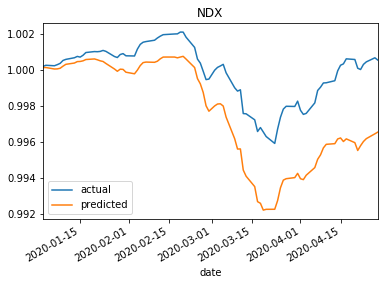

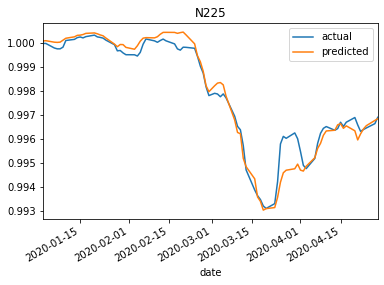

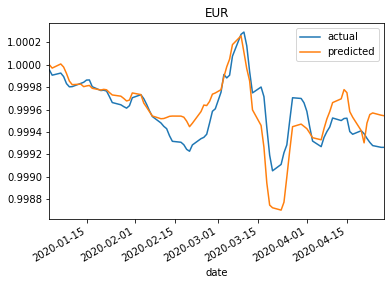

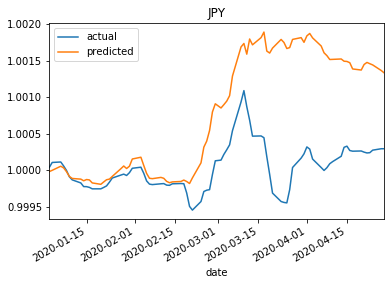

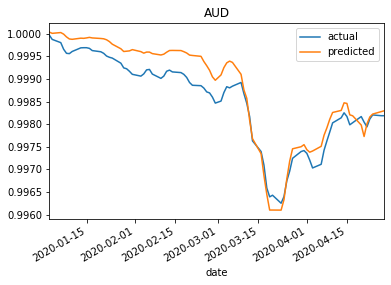

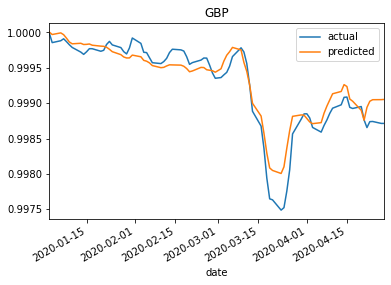

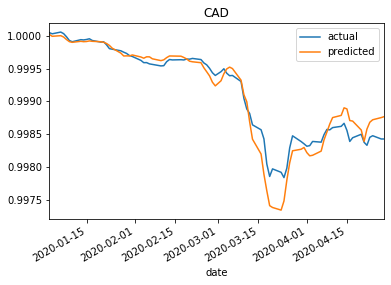

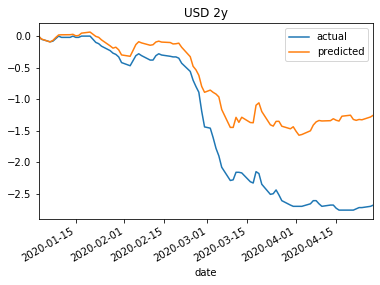

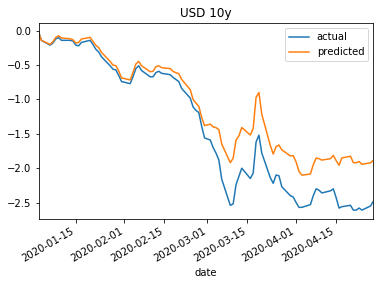

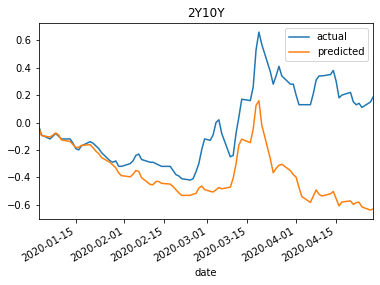

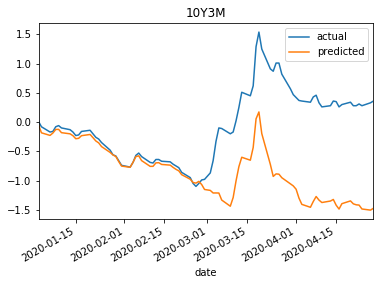

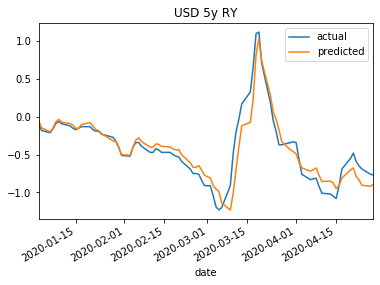

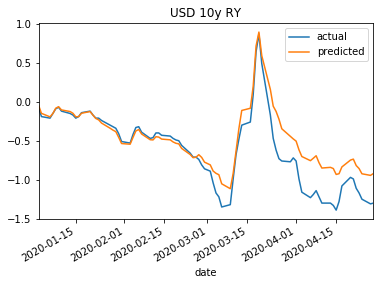

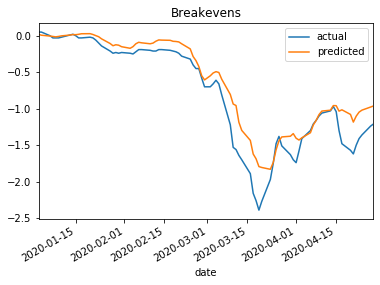

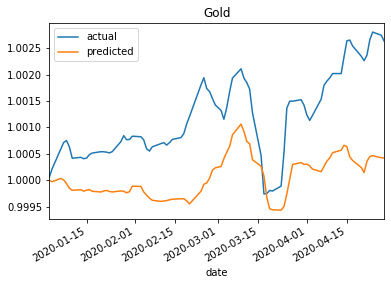

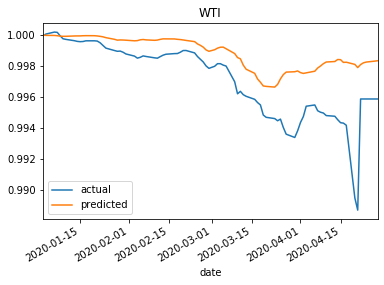

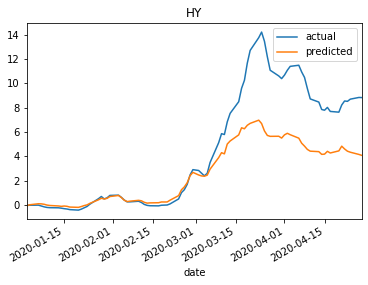

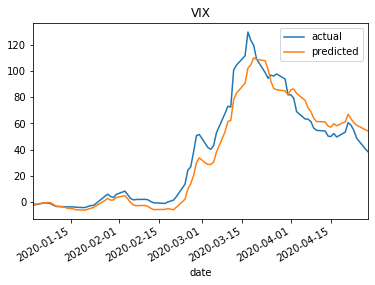

In [64]:
# compare each of the variables since beginning of the year
since = '2020-01-01'
predicted = transform(res, since)
actual = transform(frame_t, since)

for asset in frame_t.columns:
    compare_plot(asset, actual, predicted)

### What's New

* New `IRCMSSpreadOption` instrument (`from gs_quant.instruments import IRCMSSpreadOption`)
* New tunable epidemiological models (SIR, SEIR, age-stratified SEIR) (`from gs_quant.models.epidemiology import SIR, SEIR, SEIRCMAgeStratified`)   
* New timeseries functions (percentile, conditional funcs, exponential_moving_average) (`from gs_quant.timeseries import *`)
* Added discount factor information to the `Cashflows` measure
* `to_frame()` function for portfolios now supports nested portfolios
* `gs-quant` now compatible with `pandas` versions > 1.0.0